In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [4]:
train_file = 'data/in/train.csv'
test_file = 'data/in/test.csv'

train_data = pd.read_csv(train_file,index_col=0)
test_data = pd.read_csv(test_file,index_col=0)

In [5]:
train_data.head()

,FECHA,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,DISTANCIA,TIEMPO
ID,,,,,,,
124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0
124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0
124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0
124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0
124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0


In [6]:
la_orig = train_data['LATITUD_ORIGEN'].values
lo_orig = train_data['LONGITUD_ORIGEN'].values
la_dest = train_data['LATITUD_DESTINO'].values
lo_dest = train_data['LONGITUD_DESTINO'].values

distances = []
states_orig = []
states_dest = []
for la1, lo1, la2, lo2 in zip(la_orig,lo_orig,la_dest,lo_dest):
    dist = geopy.distance.distance((la1,lo1),(la2,lo2)).m
    distances.append(dist)

train_data['EARTH_DISTANCE'] = distances

In [7]:
train_data = train_data.drop(train_data[train_data['EARTH_DISTANCE']>=300000].index)

In [8]:
train_data.head()

,FECHA,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,DISTANCIA,TIEMPO,EARTH_DISTANCE
ID,,,,,,,,
124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,11709.759288
124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,11104.026667
124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,44070.222890
124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,20401.135922
124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,9285.408508


In [9]:
la_orig = test_data['LATITUD_ORIGEN'].values
lo_orig = test_data['LONGITUD_ORIGEN'].values
la_dest = test_data['LATITUD_DESTINO'].values
lo_dest = test_data['LONGITUD_DESTINO'].values

distances = []
for la1, lo1, la2, lo2 in zip(la_orig,lo_orig,la_dest,lo_dest):
    dist = geopy.distance.distance((la1,lo1),(la2,lo2)).m
    distances.append(dist)

test_data['EARTH_DISTANCE'] = distances

In [10]:
test_data.head()

,FECHA,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,EARTH_DISTANCE
ID,,,,,,
124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,37618.751360
124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,68841.223973
124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,9532.156469
124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,10185.051111
124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,8633.569104


In [11]:
X=train_data.iloc[:,[False,True,True,True,True,False,False,True]].values
y=train_data.iloc[:,5:-1].values
yhat=test_data.iloc[:,1:].values

In [12]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, 0.54753148, 0.03653944],
       [0.74842017, 0.22806174, 0.72358461, 0.26564229, 0.06726531],
       [0.4134065 , 0.34430488, 0.41945535, 0.35188306, 0.00889957],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, 0.34470825, 0.01789533],
       [0.40340026, 0.3552709 , 0.42098601, 0.39107818, 0.04980804],
       [0.15010318, 0.93230005, 0.23882396, 0.90311374, 0.13651709]])

In [13]:
from keras.optimizers import Adam

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer='adam')
    return model

In [14]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

5 2


In [15]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try4.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try4.csv')
    
    return [callback1,callback2]

In [16]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=300, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/300
50/50 [==============================] - 2s 24ms/step - loss: 90.5251 - val_loss: 73.4115

Epoch 00001: loss improved from inf to 83.58145, saving model to data/out\try4.h5
Epoch 2/300
50/50 [==============================] - 0s 2ms/step - loss: 69.8363 - val_loss: 58.0027

Epoch 00002: loss improved from 83.58145 to 66.00183, saving model to data/out\try4.h5
Epoch 3/300
50/50 [==============================] - 0s 2ms/step - loss: 54.2868 - val_loss: 42.5195

Epoch 00003: loss improved from 66.00183 to 50.41769, saving model to data/out\try4.h5
Epoch 4/300
50/50 [==============================] - 0s 2ms/step - loss: 38.6040 - val_loss: 26.9758

Epoch 00004: loss improved from 50.41769 to 34.79576, saving model to data/out\try4.h5
Epoch 5/300
50/50 [==============================] - 0s 2ms/step - loss: 25.4216 - val_loss: 23.7865

Epoch 00005: loss improved from 34.79576 to 24.11755, saving model to data/out\try4.h5
Epoch 6/300
50/50 [==============================] - 0s 2ms

50/50 [==============================] - 0s 2ms/step - loss: 20.7220 - val_loss: 21.7961

Epoch 00047: loss improved from 20.64127 to 20.59197, saving model to data/out\try4.h5
Epoch 48/300
50/50 [==============================] - 0s 2ms/step - loss: 20.5488 - val_loss: 21.7443

Epoch 00048: loss improved from 20.59197 to 20.49838, saving model to data/out\try4.h5
Epoch 49/300
50/50 [==============================] - 0s 2ms/step - loss: 21.1752 - val_loss: 20.9901

Epoch 00049: loss improved from 20.49838 to 20.47176, saving model to data/out\try4.h5
Epoch 50/300
50/50 [==============================] - 0s 2ms/step - loss: 20.4870 - val_loss: 21.5555

Epoch 00050: loss did not improve from 20.47176
Epoch 51/300
50/50 [==============================] - 0s 2ms/step - loss: 20.1102 - val_loss: 20.7591

Epoch 00051: loss improved from 20.47176 to 20.42845, saving model to data/out\try4.h5
Epoch 52/300
50/50 [==============================] - 0s 2ms/step - loss: 20.3405 - val_loss: 20.8817


50/50 [==============================] - 0s 2ms/step - loss: 19.1726 - val_loss: 19.7182

Epoch 00095: loss did not improve from 19.17443
Epoch 96/300
50/50 [==============================] - 0s 2ms/step - loss: 19.9270 - val_loss: 20.0196

Epoch 00096: loss did not improve from 19.17443
Epoch 97/300
50/50 [==============================] - 0s 2ms/step - loss: 19.4596 - val_loss: 19.7291

Epoch 00097: loss did not improve from 19.17443
Epoch 98/300
50/50 [==============================] - 0s 2ms/step - loss: 19.6590 - val_loss: 19.6960

Epoch 00098: loss did not improve from 19.17443
Epoch 99/300
50/50 [==============================] - 0s 2ms/step - loss: 19.4491 - val_loss: 19.6794

Epoch 00099: loss improved from 19.17443 to 19.17010, saving model to data/out\try4.h5
Epoch 100/300
50/50 [==============================] - 0s 2ms/step - loss: 19.2201 - val_loss: 19.7877

Epoch 00100: loss improved from 19.17010 to 19.12891, saving model to data/out\try4.h5
Epoch 101/300
50/50 [=======

50/50 [==============================] - 0s 2ms/step - loss: 18.9002 - val_loss: 20.0498

Epoch 00146: loss improved from 18.83186 to 18.80469, saving model to data/out\try4.h5
Epoch 147/300
50/50 [==============================] - 0s 2ms/step - loss: 18.7952 - val_loss: 19.4728

Epoch 00147: loss did not improve from 18.80469
Epoch 148/300
50/50 [==============================] - 0s 2ms/step - loss: 19.6186 - val_loss: 19.3398

Epoch 00148: loss did not improve from 18.80469
Epoch 149/300
50/50 [==============================] - 0s 2ms/step - loss: 19.1641 - val_loss: 19.5039

Epoch 00149: loss improved from 18.80469 to 18.78015, saving model to data/out\try4.h5
Epoch 150/300
50/50 [==============================] - 0s 2ms/step - loss: 19.3236 - val_loss: 19.3284

Epoch 00150: loss did not improve from 18.78015
Epoch 151/300
50/50 [==============================] - 0s 2ms/step - loss: 18.9320 - val_loss: 19.3461

Epoch 00151: loss did not improve from 18.78015
Epoch 152/300
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: 19.0490 - val_loss: 19.2878

Epoch 00199: loss did not improve from 18.69957
Epoch 200/300
50/50 [==============================] - 0s 2ms/step - loss: 18.2829 - val_loss: 19.9904

Epoch 00200: loss did not improve from 18.69957
Epoch 201/300
50/50 [==============================] - 0s 2ms/step - loss: 19.5618 - val_loss: 19.3969

Epoch 00201: loss did not improve from 18.69957
Epoch 202/300
50/50 [==============================] - 0s 2ms/step - loss: 19.1280 - val_loss: 19.3124

Epoch 00202: loss improved from 18.69957 to 18.69771, saving model to data/out\try4.h5
Epoch 203/300
50/50 [==============================] - 0s 2ms/step - loss: 18.1338 - val_loss: 19.5714

Epoch 00203: loss did not improve from 18.69771
Epoch 204/300
50/50 [==============================] - 0s 2ms/step - loss: 19.0411 - val_loss: 19.3389

Epoch 00204: loss did not improve from 18.69771
Epoch 205/300
50/50 [==============================] - 0s 2ms/s

50/50 [==============================] - 0s 1ms/step - loss: 19.0936 - val_loss: 19.4174

Epoch 00252: loss did not improve from 18.64475
Epoch 253/300
50/50 [==============================] - 0s 2ms/step - loss: 18.8243 - val_loss: 19.2738

Epoch 00253: loss did not improve from 18.64475
Epoch 254/300
50/50 [==============================] - 0s 2ms/step - loss: 18.8011 - val_loss: 19.3244

Epoch 00254: loss did not improve from 18.64475
Epoch 255/300
50/50 [==============================] - 0s 2ms/step - loss: 18.5102 - val_loss: 19.2935

Epoch 00255: loss did not improve from 18.64475
Epoch 256/300
50/50 [==============================] - 0s 2ms/step - loss: 18.2824 - val_loss: 19.4998

Epoch 00256: loss did not improve from 18.64475
Epoch 257/300
50/50 [==============================] - 0s 2ms/step - loss: 18.9796 - val_loss: 19.2754

Epoch 00257: loss did not improve from 18.64475
Epoch 258/300
50/50 [==============================] - 0s 2ms/step - loss: 18.4574 - val_loss: 19.5425

In [17]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try4.h5')

ypred = best_model_tf.predict(yhat)

In [18]:
print(ypred)

[[ 50300.074    3572.5603]
 [ 91850.11     5568.3145]
 [ 12883.475    1528.6354]
 ...
 [ 25099.568    2350.143 ]
 [ 68245.03     4465.6323]
 [185458.14    10193.501 ]]


In [19]:
best_model_tf.evaluate(X,y)

62/62 [==============================] - 0s 705us/step - loss: 18.8457


18.845727920532227

In [20]:
ids = pd.read_csv(test_file)
ids_1 = ids['ID']

In [21]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   50300.074219   3572.560303
1    124093149   91850.109375   5568.314453
2    124090750   12883.474609   1528.635376
3    124092491   13758.041992   1598.050049
4    124091871   11679.219727   1434.753418
..         ...            ...           ...
847  124088805   13407.935547   1569.497559
848  124089757   11636.964844   1431.213867
849  124089569   25099.568359   2350.143066
850  124092518   68245.031250   4465.632324
851  124090644  185458.140625  10193.500977

[852 rows x 3 columns]


In [22]:
df.to_csv('data/out/try4_out.csv',index=False)

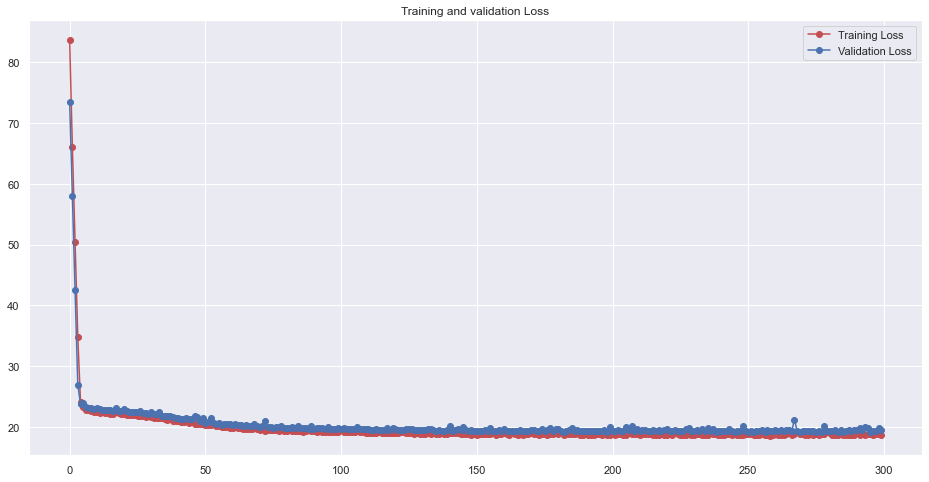

<Figure size 432x288 with 0 Axes>

In [23]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()